In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle/'
!kaggle competitions download -c tensorflow-speech-recognition-challenge
!unzip *.zip
!7za x 'train.7z'

100% 3.50G/3.50G [02:41<00:00, 26.6MB/s]
100% 3.50G/3.50G [02:41<00:00, 23.4MB/s]
Archive:  tensorflow-speech-recognition-challenge.zip
  inflating: link_to_gcp_credits_form.txt  
  inflating: sample_submission.7z    
  inflating: test.7z                 
  inflating: train.7z                

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 38 - train/audio/_background_noise_/doing_the_dishes.wav                                                             

In [ ]:
!7za x 'test.7z'


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 2640679130 bytes (2519 MiB)

Extracting archive: test.7z
--
Path = test.7z
Type = 7z
Physical Size = 2640679130
Headers Size = 1345163
Method = Delta LZMA2:24
Solid = +
Blocks = 3

  0%      0% 100 - test/audio/clip_002716f99.wav                                          0% 214 - test/audio/clip_0056e9360.wav                                          0% 329 - test/audio/clip_0088111f0.wav                                          0% 443 - test/audio/clip_00c2578c8.wav

In [4]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import IPython.display as ipd
import plotly as py
import plotly.graph_objs as go

In [5]:
files = []
target_series = []
for dirname, _, filenames in os.walk('/content/train/audio/'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        target = filepath.split('/')[-2]
        if target not in '_background_noise_':
            target_series.append(target)
            files.append(filepath)
data = pd.DataFrame(target_series, columns=['target'])
data['filename'] = files
data = data.sample(frac=1)
data = data.reset_index(drop=True)
data.head()

target                                           filename
0  sheila  /content/train/audio/sheila/380abbad_nohash_0.wav
1    zero    /content/train/audio/zero/e5d2e09d_nohash_0.wav
2  marvin  /content/train/audio/marvin/7d5f87c8_nohash_0.wav
3   house   /content/train/audio/house/4d4e17f5_nohash_1.wav
4     six     /content/train/audio/six/c5e3817f_nohash_0.wav

In [6]:
data.shape

(62346, 2)

In [ ]:
#df.shape

In [7]:
df = pd.DataFrame()
for target in data['target'].unique():
    df = df.append(data[data['target']==target].sample(150))
df = df.sample(frac=1)
df = df.reset_index(drop=True)
df.head()

<ipython-input-7-a93b282b541a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[data['target']==target].sample(150))
<ipython-input-7-a93b282b541a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[data['target']==target].sample(150))
<ipython-input-7-a93b282b541a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[data['target']==target].sample(150))
<ipython-input-7-a93b282b541a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[data['target']==target].sample(150))
<ipython-input-7-a93b282b541a>:3: FutureWarning: The frame.append method is deprecated and will 

target                                         filename
0   zero  /content/train/audio/zero/e48a80ed_nohash_1.wav
1    off   /content/train/audio/off/9a43b64b_nohash_1.wav
2   down  /content/train/audio/down/518588b6_nohash_1.wav
3   down  /content/train/audio/down/f92e49f3_nohash_1.wav
4   zero  /content/train/audio/zero/31270cb2_nohash_0.wav

In [8]:
df.shape

(4350, 2)

In [9]:
def create_mfcc_features(path):
    mfccs = []
    try:
        x , sr = librosa.load(path)
        mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128)
        mfccs = np.mean(mfccs.T,axis=0)
    except:
        print('Error reading audio')
    return mfccs

In [10]:
X_df = pd.DataFrame(df['filename'].apply(lambda x: create_mfcc_features(x)).tolist())

In [11]:
X_df.head()

0           1          2          3          4          5    \
0 -406.074341  133.817123 -30.648254  18.178705   1.857143  21.822996   
1 -621.482849  142.425400 -20.075050  26.524220 -32.460915  27.380915   
2 -438.828217  124.870331 -47.060318  29.721342 -24.857941   0.050589   
3 -390.050812  108.917259  -8.224467  13.881952   9.157888 -12.494353   
4 -448.427521  156.304306 -34.928310   6.984028  24.101631 -26.565521   

         6          7          8         9    ...       118       119  \
0  -3.979334   0.818944   0.901808 -0.577164  ... -0.296428  0.395059   
1   0.525406  10.862525  -7.908325 -4.759419  ...  0.314874  0.388816   
2  -6.620838   0.954411  -6.237436 -7.689254  ...  0.111493  0.180860   
3 -11.456908   0.114462 -13.050250 -7.437277  ...  0.017445 -0.344032   
4  -4.859507   6.960577 -14.284926  0.931696  ...  0.834690  0.651943   

        120       121       122       123       124       125       126  \
0 -0.710148 -0.248735 -0.460384 -0.661195  0.273005 -0.539322  0.188246   
1  0.842851  0.541998  0.059412  0.364769  0.057490  0.383446  0.173275   
2  0.400493 -0.019949  0.085482  0.778947 -0.395816  0.018836 -0.105855   
3 -0.093480 -0.538309 -0.210435  0.358114  0.000778  0.194126 -0.027106   
4  0.390358  0.136386 -0.104821 -0.008529  0.001317 -0.566859 -0.806125   

        127  
0  0.295562  
1 -0.089003  
2  0.152874  
3  0.260958  
4 -0.344314  

[5 rows x 128 columns]

# MODELS

In [12]:
X_df.shape

(4350, 128)

In [13]:
encoder = LabelEncoder()
encoder.fit(df['target'])
y = encoder.transform(df['target'])

In [14]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

In [15]:
x_train, x_val, y_train, y_val = train_test_split(np.array(X_df), y, test_size=0.10, stratify=y)

In [16]:
x_train = x_train.reshape(x_train.shape[0], 16, 8, 1)
x_val = x_val.reshape(x_val.shape[0], 16, 8, 1)

In [17]:
x_train.shape

(3915, 16, 8, 1)

In [18]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(16, 8, 1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = "same"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding = "same"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(data['target'].unique()), activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 8, 16)         160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 4, 16)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 8)           1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 2, 8)           0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1

In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
123/123 [==============================] - 2s 6ms/step - loss: 5.2416 - accuracy: 0.0365
Epoch 2/200
123/123 [==============================] - 1s 6ms/step - loss: 3.3562 - accuracy: 0.0404
Epoch 3/200
123/123 [==============================] - 1s 6ms/step - loss: 3.3311 - accuracy: 0.0564
Epoch 4/200
123/123 [==============================] - 1s 6ms/step - loss: 3.2926 - accuracy: 0.0677
Epoch 5/200
123/123 [==============================] - 1s 6ms/step - loss: 3.2265 - accuracy: 0.0792
Epoch 6/200
123/123 [==============================] - 1s 6ms/step - loss: 3.1754 - accuracy: 0.0777
Epoch 7/200
123/123 [==============================] - 1s 8ms/step - loss: 3.1179 - accuracy: 0.0932
Epoch 8/200
123/123 [==============================] - 1s 9ms/step - loss: 3.0660 - accuracy: 0.1073
Epoch 9/200
123/123 [==============================] - 1s 9ms/step - loss: 3.0067 - accuracy: 0.1180
Epoch 10/200
123/123 [==============================] - 1s 9ms/step - loss: 2.9510 - accura

In [21]:
prob_val = model.predict(x_val)
pred_val = np.argmax(prob_val, axis=1)
pred_val = encoder.inverse_transform(pred_val)

14/14 [==============================] - 0s 4ms/step


<Axes: >

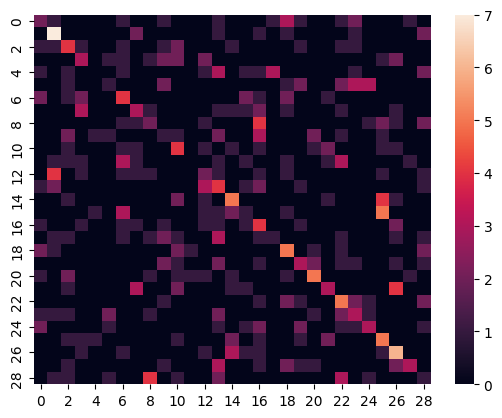

In [22]:
sns.heatmap(confusion_matrix(encoder.inverse_transform(y_val), pred_val))

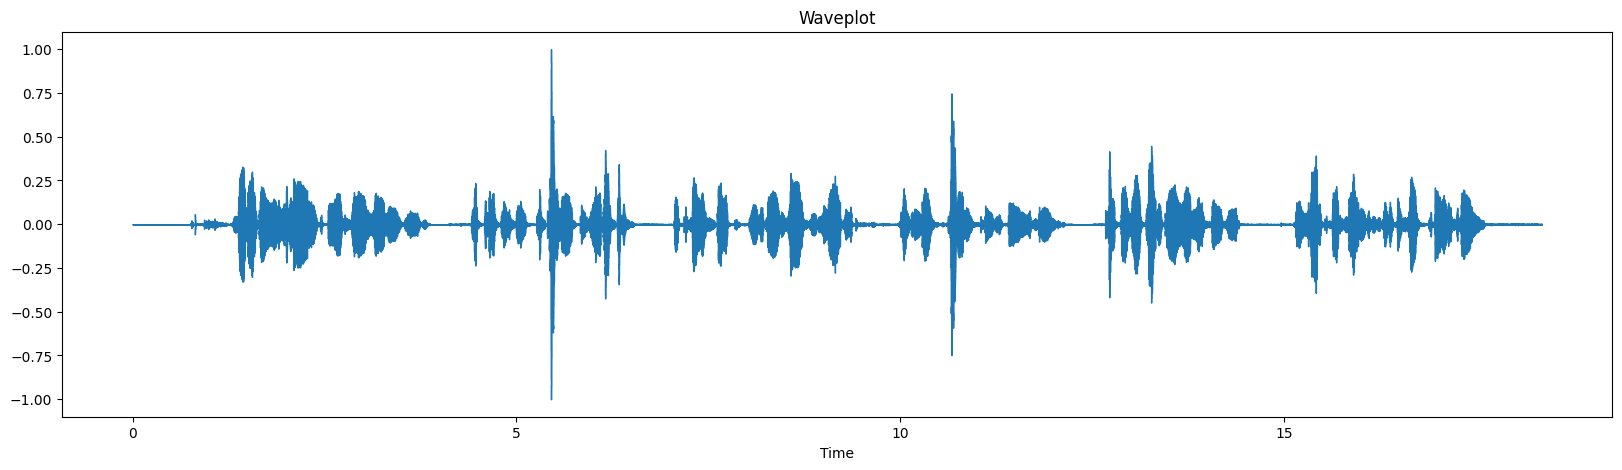

In [27]:
x , sr = librosa.load('/content/sample_audio.wav')
plt.figure(figsize=(20, 5))
plt.title('Waveplot')
librosa.display.waveshow(x, sr=sr)
plt.show()

In [28]:
x.shape

(404754,)

In [24]:
#ipd.Audio('/content/my_audio.mp4')

In [29]:
x , sr = librosa.load('/content/train/audio/eight/00b01445_nohash_0.wav')

In [30]:
total_time = x.shape[0]/sr
per_window = x.shape[0]/total_time
total_time, per_window

(1.0, 22050.0)

In [31]:
mfccs = librosa.feature.mfcc(y=x[int(2.3*per_window):int(2.6*per_window)], sr=sr, n_mfcc=128)
mfccs = np.mean(mfccs.T,axis=0)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


In [32]:
mfccs.shape

(128,)

In [33]:
x_test = mfccs.reshape(1, 16, 8, 1)
x_test

array([[[[-1131.3708],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ]],

        [[    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ]],

        [[    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ]],

        [[    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ]],

        [[    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ],
         [    0.    ]],

        [[    0.    ],
         [    0.    ],
         [    0.    ],
 

In [34]:
prob_val = model.predict(x_test)
pred_val = np.argmax(prob_val, axis=1)
pred_val = encoder.inverse_transform(pred_val)

1/1 [==============================] - 0s 47ms/step


In [35]:
model.save("mode1_test.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
pred_val

array(['on'], dtype=object)